# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/InformationBottleneck')
sys.path.append('/content/drive/MyDrive/MLMI_InfoBottleneck')

Mounted at /content/drive


Install MMCV

In [2]:
pip install mmcv;

In [3]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import iba
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import iba
    
from iba.models.pytorch import IBA, tensor_to_np_img
from iba.models.pytorch_img_iba import Image_IBA
from iba.models.net import Net
from iba.models.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


## Loading Data and Model

In [4]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
image_dir = '/content/drive/MyDrive/InformationBottleneck/imgs'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'

dev = torch.device('cuda:0')
# dev = torch.device('cpu:0')

# select a model to analyse
model = torchvision.models.vgg16(pretrained=True)
# model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()

# load the data
if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224
    
valset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        Resize((image_size, image_size)), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

trainset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        Resize((image_size, image_size)), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

with open(os.path.join(prak_dir, 'imagenet_class_index.json')) as f:
    idx2class = {int(k): v[1] for k, v in json.load(f).items()}

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
img, target = valset[0]

# Information bottleneck

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck, the value of beta, and sigma for mask smoothing. 

In [5]:
if type(model) == torchvision.models.vgg.VGG:
    iba = IBA(model.features[17])
elif type(model) == torchvision.models.resnet.ResNet:
    iba = IBA(model.layer2)
elif type(model) == torchvision.models.inception.Inception3:
    iba = IBA(model.Mixed_5b)

In [6]:
iba.sigma = None
iba.beta = 20
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [7]:
iba.estimate(model, trainloader, device=dev, n_samples=10, progbar=True)

In [8]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean -8.71 and std 11.81


In [9]:
iba.estimator.n_samples()

64

# Information flow to generate image level attribution map
Uncomment code above to show result for sample image

In [10]:
import random
idx = random.randint(0,9999)
print(idx)
img, target = valset[idx]
# target = 382  # 382: squirrel monkey #677 nail 817 sports car
# # preprocess image
# img  = Compose([
#     Resize((image_size, image_size)), ToTensor(),  
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])(Image.open(os.path.join(image_dir, "monkeys.jpg")))
# print(img.shape)
net = Net(image=img, target=target, epochs=10, model=model, position="features[17]", IBA=iba, image_ib_beta=20, image_ib_opt_steps=60, device=dev)

3735


## Train image mask

In [11]:
net.train()

2021-02-01 21:01:46,086 - iba - INFO - Training on IB
/content/drive/MyDrive/InformationBottleneck/iba/models/pytorch.py:571: UserWarning: Selected estimator was only fitted on 64 samples. Might not be enough! We recommend 10.000 samples.
  f"Selected estimator was only fitted on {self.estimator.n_samples()} "
2021-02-01 21:01:47,895 - iba - INFO - Training on GAN


WGAN_CP init model.


2021-02-01 21:01:49,651 - iba - INFO - [Epoch1/10], [0/7], D loss: 0.01417, G loss: 0.00581
2021-02-01 21:01:53,198 - iba - INFO - [Epoch1/10], [5/7], D loss: -0.01139, G loss: 0.01037
2021-02-01 21:01:54,611 - iba - INFO - [Epoch2/10], [0/7], D loss: -0.01416, G loss: 0.01190
2021-02-01 21:01:58,196 - iba - INFO - [Epoch2/10], [5/7], D loss: -0.02982, G loss: 0.02123
2021-02-01 21:01:59,627 - iba - INFO - [Epoch3/10], [0/7], D loss: -0.03705, G loss: 0.02504
2021-02-01 21:02:03,241 - iba - INFO - [Epoch3/10], [5/7], D loss: -0.06576, G loss: 0.04153
2021-02-01 21:02:04,679 - iba - INFO - [Epoch4/10], [0/7], D loss: -0.08300, G loss: 0.05183
2021-02-01 21:02:08,293 - iba - INFO - [Epoch4/10], [5/7], D loss: -0.15026, G loss: 0.09015
2021-02-01 21:02:09,722 - iba - INFO - [Epoch5/10], [0/7], D loss: -0.18910, G loss: 0.11142
2021-02-01 21:02:13,344 - iba - INFO - [Epoch5/10], [5/7], D loss: -0.32715, G loss: 0.18458
2021-02-01 21:02:14,792 - iba - INFO - [Epoch6/10], [0/7], D loss: -0.3

##Display original image

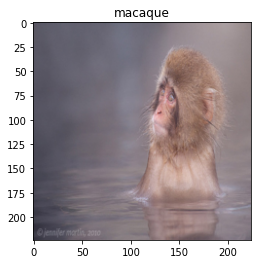

In [14]:
net.plot_image(idx2class[target])

## Display feature mask from IB (already summed over channels)
To get a feature mask with image size, use upscale=True as parameter

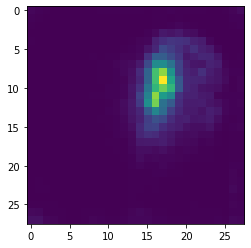

In [22]:
net.show_feat_mask()

## Display generated image mask from GAN

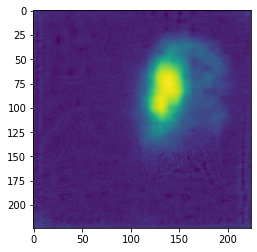

In [20]:
net.show_gen_img_mask()

## Display final image mask learned from image IB

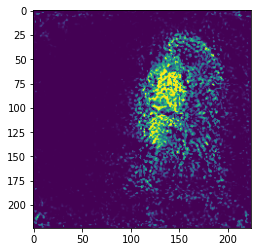

In [17]:
net.show_img_mask()